# Explore the dataset


In this notebook, we will perform an EDA (Exploratory Data Analysis) on the processed Waymo dataset (data in the `processed` folder). In the first part, you will create a function to display 

In [1]:
from utils import get_dataset
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline
import tensorflow as tf
# tf.executing_eagerly()


### Loading the datasets
We also load the validation datatset for the exploration here since there seem to be only few cyclist data als we want to amke sure that some also made it into the validation set.

In [2]:
record_files_train_search_expr = "data/train/*"
record_files_val_search_expr = "data/val/*"

dataset_train = get_dataset(record_files_train_search_expr)
dataset_validation = get_dataset(record_files_val_search_expr)
# dataset = get_dataset(records[0])

INFO:tensorflow:Reading unweighted datasets: ['data/train/*']
INFO:tensorflow:Reading record datasets for input file: ['data/train/*']
INFO:tensorflow:Number of filenames to read: 80
Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_deterministic`.
Instructions for updating:
Use `tf.data.Dataset.map()


2021-11-29 14:23:51.248920: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-29 14:23:52.177264: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10525 MB memory:  -> device: 0, name: NVIDIA TITAN V, pci bus id: 0000:65:00.0, compute capability: 7.0


INFO:tensorflow:Reading unweighted datasets: ['data/val/*']
INFO:tensorflow:Reading record datasets for input file: ['data/val/*']
INFO:tensorflow:Number of filenames to read: 15


The get the size of a dataset turned out to be rather cumbersome as the cardinality method does not seem to work properly and iterations so not end. The solution below with a more primitive data loader did the trick for this purpose, but teh thos loaded data cannot be used for the explorations below.

In [3]:
import glob
records_train = glob.glob(record_files_train_search_expr)
records_val = glob.glob(record_files_val_search_expr)

train_set = tf.data.TFRecordDataset(records_train, compression_type='')
val_set = tf.data.TFRecordDataset(records_val, compression_type='')

num_train_images = 0
for ele in train_set:
    num_train_images+=1
num_val_images = 0
for ele in val_set:
    num_val_images+=1
print("There are", num_train_images, "images in the training dataset and", num_val_images, "in the validation dataset.")

2021-11-29 14:23:53.747677: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


There are 15862 images in the training dataset and 2948 in the validation dataset.


## Write a function to display an image and the bounding boxes

Implement the `display_instances` function below. This function takes a batch as an input and display an image with its corresponding bounding boxes. The only requirement is that the classes should be color coded (eg, vehicles in red, pedestrians in blue, cyclist in green).

In [25]:
def display_instances(batch):
    """
    This function takes a batch from the dataset and display the image with 
    the associated bounding boxes.
    """
    # color mapping of classes
    colormap = {1: [1, 0, 0], 2: [0, 1, 0], 4: [0, 0, 1]}
    
    rows = 5
    cols = 2

    fig, ax = plt.subplots(rows, cols, figsize=(cols * 10, rows * 10))
    for i, img_data in enumerate(batch):
        x = i % rows
        y = i // rows

        img = img_data["image"]
        ax[x, y].imshow(img)

        scale_x = img.shape[1]
        scale_y = img.shape[0]

        bboxes = img_data['groundtruth_boxes'].numpy()
        classes = img_data['groundtruth_classes'].numpy()
        for cl, bb in zip(classes, bboxes):
            # print(bb)
            y1, x1, y2, x2 = bb
            x1 *= scale_x
            x2 *= scale_x
            y1 *= scale_y
            y2 *= scale_y
            rec = Rectangle((x1, y1), x2-x1, y2-y1, facecolor='none',
                            edgecolor=colormap[cl])
            ax[x, y].add_patch(rec)
        ax[x ,y].axis('off')
    plt.tight_layout()
    # plt.show()
    # plt.savefig("writeup_images/explore_display.png")

## Display 10 images 

Using the dataset created in the second cell and the function you just coded, display 10 random images with the associated bounding boxes. You can use the methods `take` and `shuffle` on the dataset.

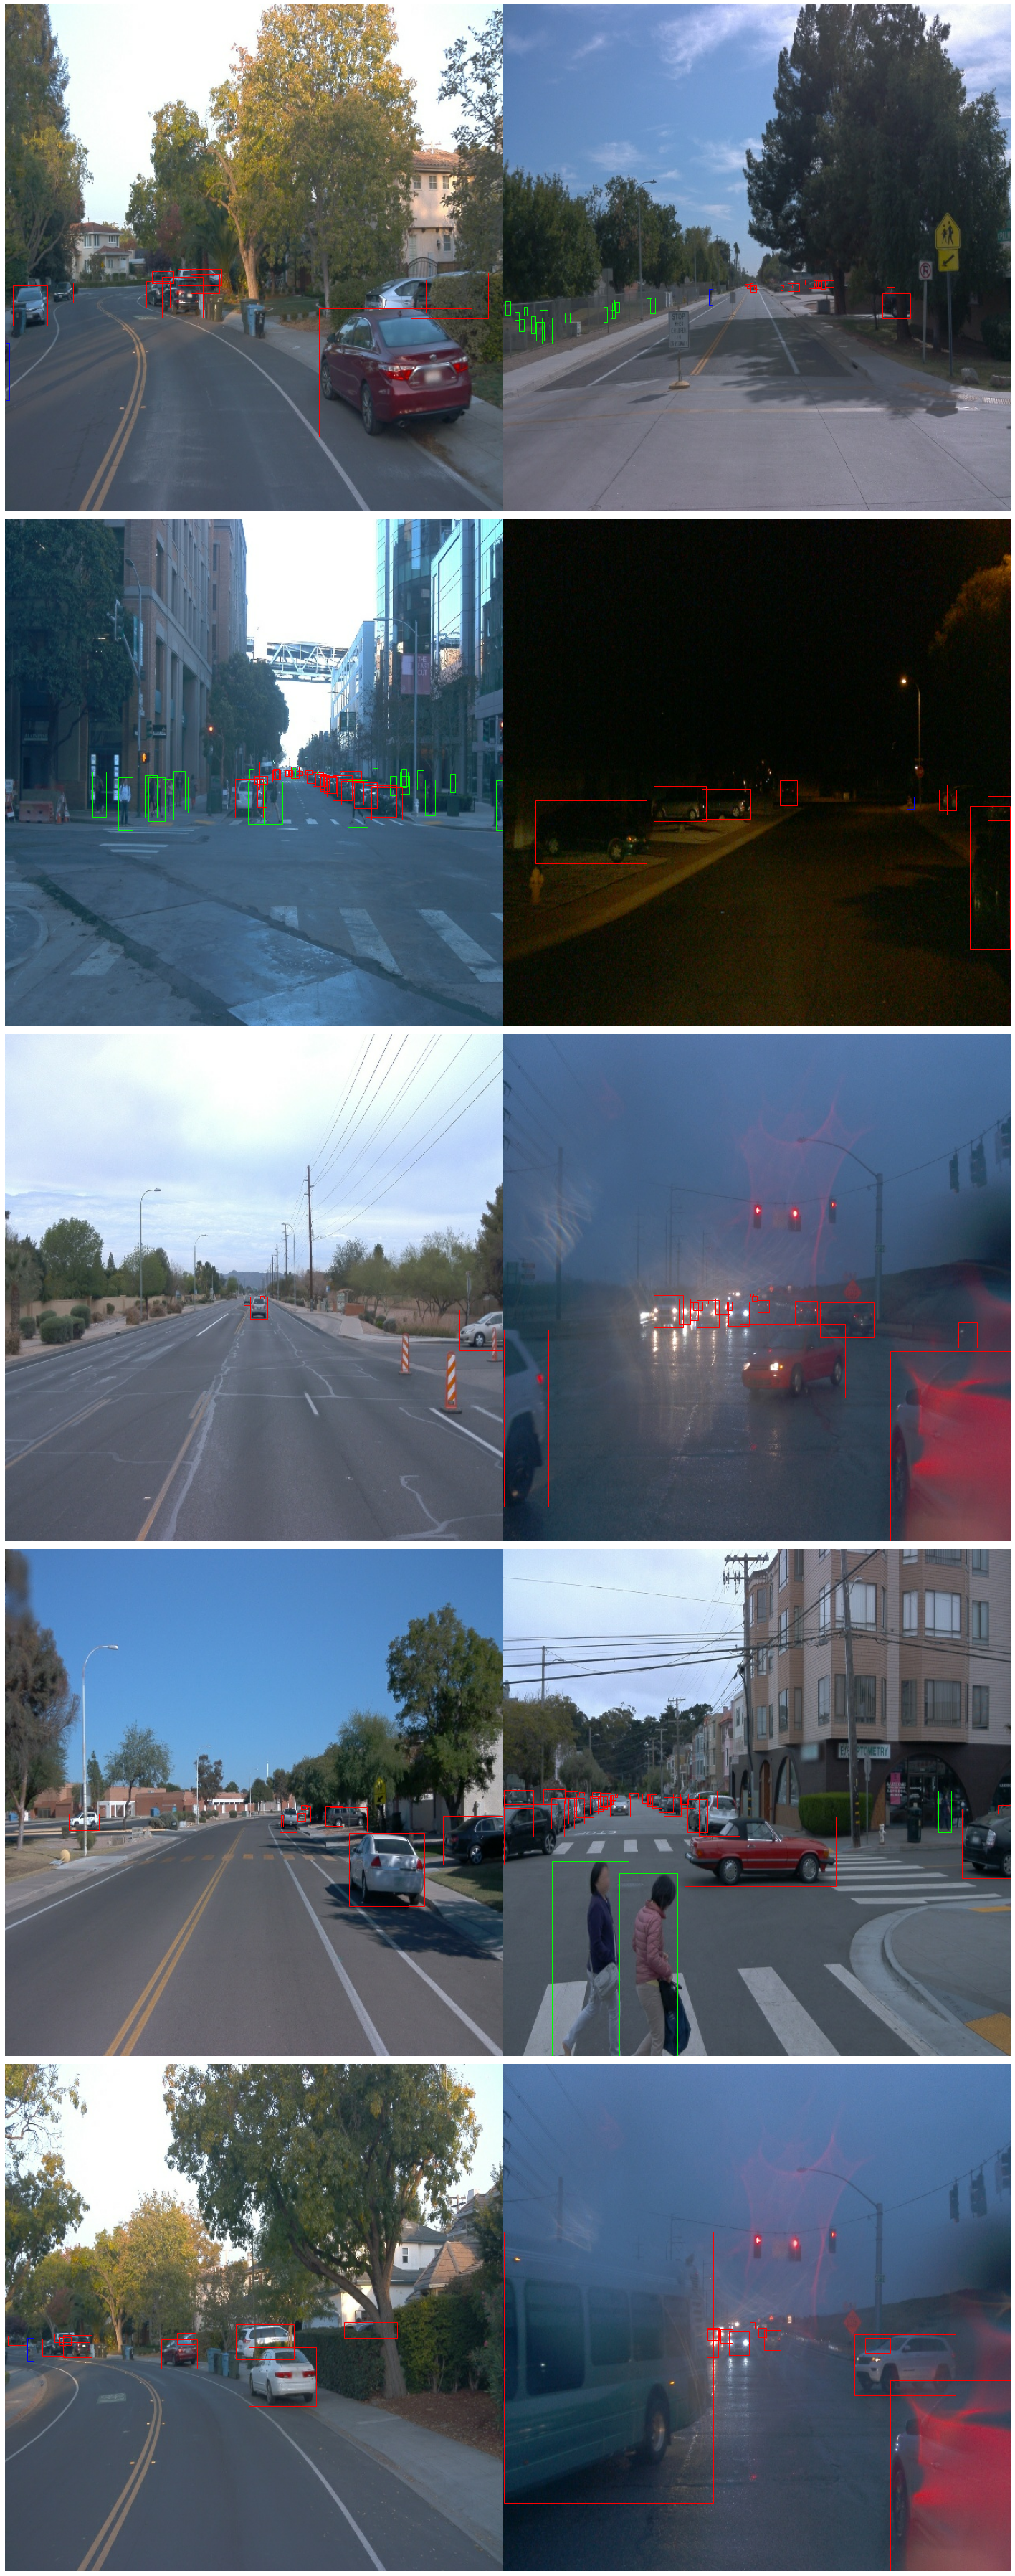

In [26]:
display_instances(dataset_train.shuffle(100, seed=42, reshuffle_each_iteration=False).take(10))

## Additional EDA

In this last part, you are free to perform any additional analysis of the dataset. What else would like to know about the data?
For example, think about data distribution. So far, you have only looked at a single file...

In [44]:
class_count = {1: 0, 2: 0, 4: 0}
for i, img_data in enumerate(dataset_train.take(15862)):
    labels = img_data['groundtruth_classes'].numpy()
    for label in labels:
        class_count[label] += 1
        
total_object_count = class_count[1] + class_count[2] + class_count[4]
        
print("Training data:")
print("Vehicles: {}, which is {:.2f} percent".format(class_count[1], class_count[1]  / total_object_count * 100))
print("Pedestrians: {}, which is {:.2f} percent".format(class_count[2], class_count[2]  / total_object_count * 100))
print("Cyclists: {}, which is {:.2f} percent".format(class_count[4], class_count[4]  / total_object_count * 100))
print()
        
class_count_eval = {1: 0, 2: 0, 4: 0}
for i, img_data in enumerate(dataset_train.take(2948)):
    labels = img_data['groundtruth_classes'].numpy()
    for label in labels:
        class_count_eval[label] += 1
total_object_count_val = class_count_eval[1] + class_count_eval[2] + class_count_eval[4]


print("Validation data:")
print("Vehicles: {}, which is {:.2f} percent".format(class_count_eval[1], class_count_eval[1]  / total_object_count_val * 100))
print("Pedestrians: {}, which is {:.2f} percent".format(class_count_eval[2], class_count_eval[2]  / total_object_count_val * 100))
print("Cyclists: {}, which is {:.2f} percent".format(class_count_eval[4], class_count_eval[4]  / total_object_count_val * 100))

Training data:
Vehicles: 282049, which is 73.69 percent
Pedestrians: 97990, which is 25.60 percent
Cyclists: 2725, which is 0.71 percent

Validation data:
Vehicles: 60290, which is 72.98 percent
Pedestrians: 21573, which is 26.12 percent
Cyclists: 744, which is 0.90 percent


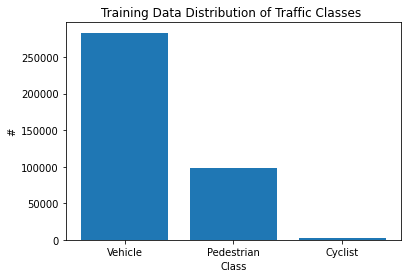

In [31]:
plt.bar([1, 2, 3], class_count.values())
plt.xticks([1, 2, 3], ['Vehicle', 'Pedestrian', 'Cyclist'])
plt.xlabel("Class")
plt.ylabel("#")
plt.title("Training Data Distribution of Traffic Classes ")
plt.savefig("writeup_images/training_data_dist.png")